In [54]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output
from torch_geometric.data import Data
import torch_geometric
from torch_geometric.loader import DataLoader, ImbalancedSampler
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch.nn import Linear
from torch_geometric.nn import MessagePassing, global_mean_pool, global_max_pool, global_add_pool
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score, precision_recall_curve
)

from sklearn.preprocessing import label_binarize
from IPython.display import Image
import matplotlib.colors as mcolors
import networkx as nx

# Load and Prepare Dataset

In [2]:
from dataset import Tox21Dataset, random_split_dataset
from trainer import Trainer
import os

## Dataset with only one classification label

In [3]:
root_dir = os.path.join(os.getcwd(),'data_1')
ds = Tox21Dataset(root=root_dir, task=['NR-AhR'])

In [4]:
train_set, val_set, test_set = random_split_dataset(ds, frac_train=0.8, frac_val=0.1, frac_test=0.1, seed=0)

In [5]:
batch_size = 64

train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in train_set.y.view(-1,2)], dtype=torch.long))
train_dataloader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

## Define simple GAT Model and train it

In [ ]:
from models import simpleGAT

In [ ]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out   = model(batch).flatten()
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = simpleGAT(in_channels=train_set[0].x.size(1), hidden_channels=32,
            out_channels=train_set[0].y.size(0), heads=4, dropout=0.2).to(device)

trainer = Trainer(model=model,
                     train_loader=train_dataloader,
                     val_loader=val_dataloader,
                     test_loader=test_dataloader,
                     device=device,
                     save_dir=os.path.join(os.getcwd(),'model_saves'),
                     save_name='GAT_1')

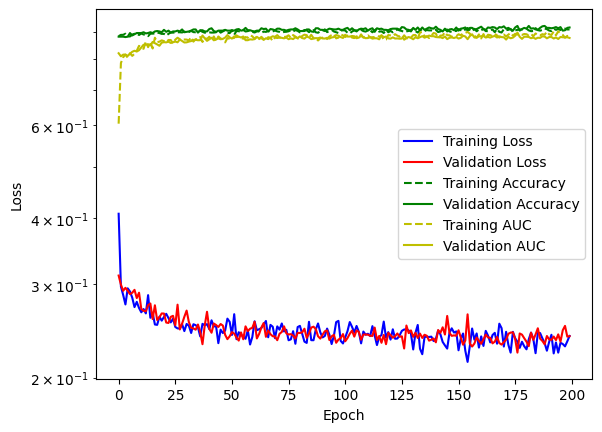

Epoch:0, Training_loss:0.4078, Training_acc:0.8833, Training_auc:0.6035, Eval_loss:0.3117, Eval_acc:0.8813, Eval_auc:0.8199
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2603, Training_acc:0.8924, Training_auc:0.8643, Eval_loss:0.2642, Eval_acc:0.9078, Eval_auc:0.8604
saving best...
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2469, Training_acc:0.8980, Training_auc:0.8810, Eval_loss:0.2472, Eval_acc:0.9109, Eval_auc:0.8711
saving best...
Epoch:60, Training_loss:0.2554, Training_acc:0.8974, Training_auc:0.8734, Eval_loss:0.2549, Eval_acc:0.9016, Eval_auc:0.8718
Epoch:80, Training_loss:0.2504, Training_acc:0.8980, Training_auc:0.8731, Eval_loss:0.2428, Eval_acc:0.9031, Eval_auc:0.8824
Epoch:100, Training_loss:0.2381, Training_acc:0.9053, Training_auc:0.8799, Eval_loss:0.2341, Eval_acc:0.9125, Eval_auc:0.8886
saving best...
Epoch:120, Training_loss:

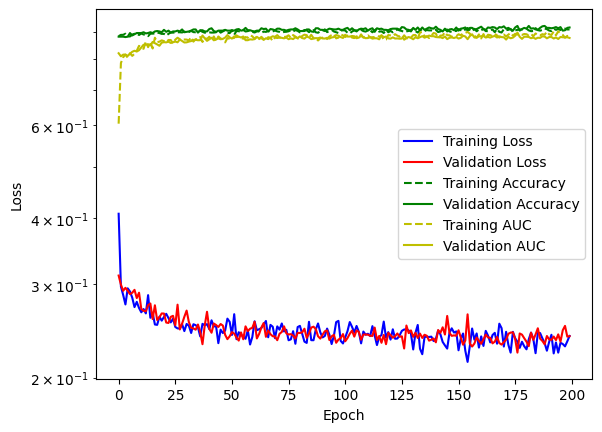

In [29]:
train_params = {'num_epochs': 200,
                'num_early_stop': 0,
                'milestones': None,
                'gamma': None}

optimizer_params = {'lr': 0.001,
                    'weight_decay': 5e-4}
                    #'momentum': 0.9}

trainer.train(train_params=train_params, optimizer_params=optimizer_params)

Test loss: 0.2786, test acc 0.8844, test_auc 0.8709


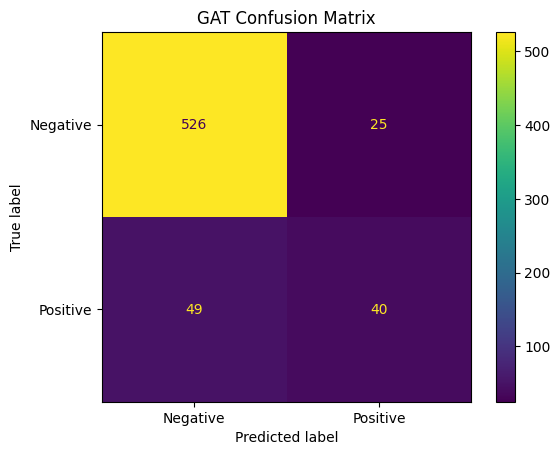

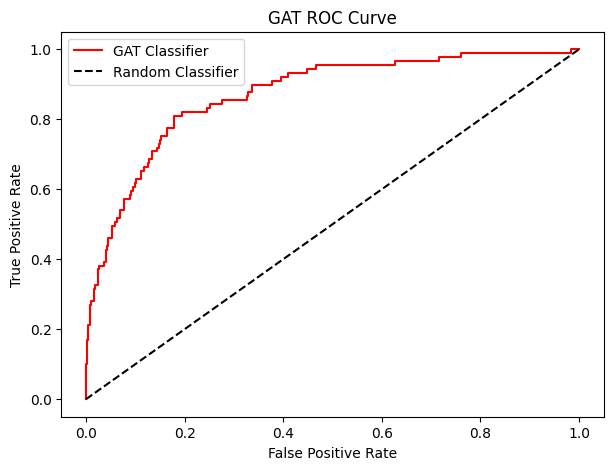

In [30]:
test_loss, test_acc, test_auc, preds, pred_probs, labels = trainer.test()

# Confusion matrix
c_matrix = confusion_matrix(labels.numpy(), preds)
disp = ConfusionMatrixDisplay(
    c_matrix, display_labels=["Negative","Positive"]
)
disp.plot() 
plt.title("GAT Confusion Matrix") 
plt.savefig('GAT_confusion.pdf')
plt.show()

# AUC by class
y_true_bin = label_binarize(labels.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = roc_curve(y_true_bin[:, 0], pred_probs.numpy())
plt.plot(fpr, tpr, "r-", label="GAT Classifier")
plt.plot([0,1], [0,1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("GAT ROC Curve") 
plt.legend() 
plt.savefig('GAT_ROC.pdf')
plt.show()

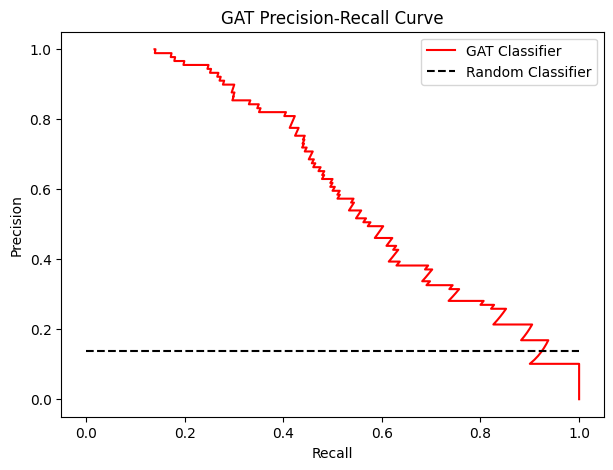

In [31]:
# AUC by class
pos_ratio = y_true_bin.sum().item()/len(y_true_bin)
y_true_bin = label_binarize(labels.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = precision_recall_curve(y_true_bin[:, 0], pred_probs.numpy())
plt.plot(fpr, tpr, "r-", label="GAT Classifier")
plt.plot([0,1], [pos_ratio,pos_ratio], "k--", label="Random Classifier")
plt.xlabel("Recall") 
plt.ylabel("Precision")
plt.title("GAT Precision-Recall Curve") 
plt.legend() 
plt.savefig('GAT_PR_curve.pdf')
plt.show()

In [32]:
from torch_geometric.explain import Explainer, GNNExplainer

In [108]:
topk = 10

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',
        ),
    threshold_config=dict(threshold_type='topk', value=topk)
    )

In [ ]:
explanation = explainer(test_set[0].x, test_set[0].edge_index, target=test_set[0].y)


/opt/anaconda3/lib/python3.13/site-packages/torch_geometric/explain/explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


In [110]:
# Generates image of most important features for node 10
path_features = "feature_importance.png"
explanation.visualize_feature_importance(path_features, top_k=10)

# Generates image of most important nodes for node 10
path_graph = "graph_importance.png"
explanation.visualize_graph(path_graph)

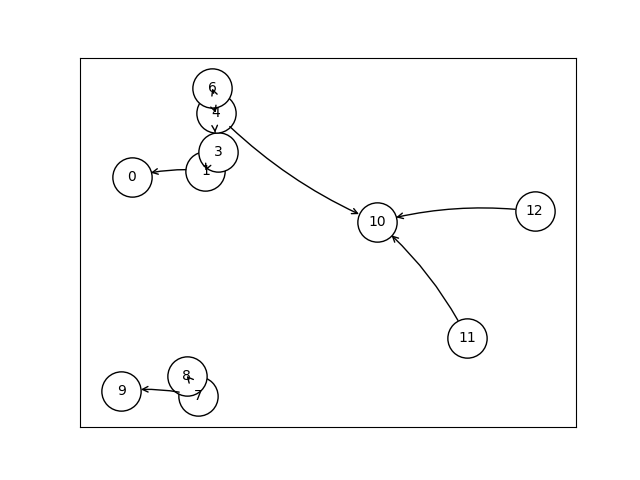

In [111]:
Image(filename=path_graph)

In [112]:
colors = list(mcolors.TABLEAU_COLORS)
def draw_graph(g: Data):
  # Get a different color for each atom type
  node_color = [colors[i.item()] for i in g.x.argmax(dim=1)]
  # Convert to networkx
  g = torch_geometric.utils.to_networkx(g, to_undirected=True)
  # Draw on screen
  nx.draw(g, node_color=node_color)

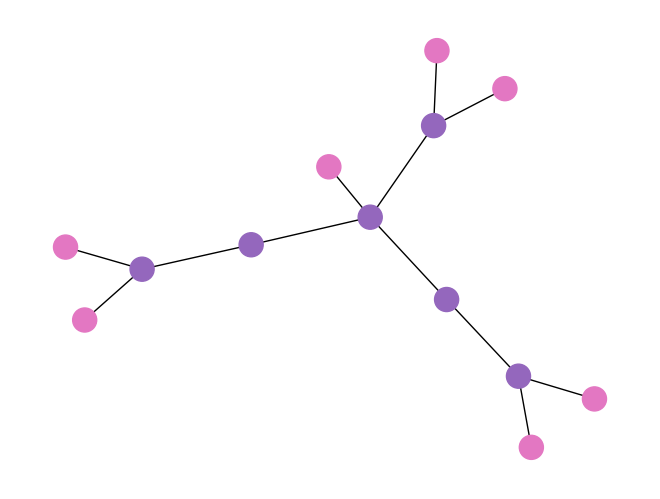

In [113]:
draw_graph(test_set[0])

In [114]:
print(explanation.edge_mask)

tensor([0.9177, 0.0000, 0.0000, 0.0000, 0.9158, 0.0000, 0.9234, 0.0000, 0.0000,
        0.0000, 0.9024, 0.9123, 0.0000, 0.0000, 0.0000, 0.9235, 0.0000, 0.9118,
        0.0000, 0.9218, 0.9142, 0.0000, 0.9118, 0.0000])


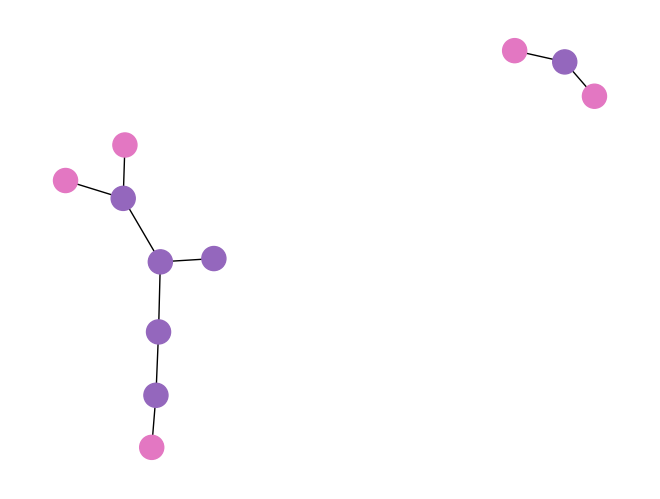

In [115]:
edges_idx = explanation.edge_mask > 0.91
subgraph = Data(test_set[0].x, test_set[0].edge_index[:, edges_idx])
subgraph = torch_geometric.transforms.RemoveIsolatedNodes()(torch_geometric.transforms.ToUndirected()(subgraph))
draw_graph(subgraph)

In [116]:
from torch_geometric.explain.metric import fidelity

In [118]:
fidp_values = []
fidm_values = []
for i in range(len(test_set)):
    explanation = explainer(test_set[i].x, test_set[i].edge_index, target=test_set[i].y)
    fidp, fidm = fidelity(explainer,explanation)
    fidp_values.append(fidp)
    fidm_values.append(fidm)

print(fidp_values)
print(fidm_values)

/opt/anaconda3/lib/python3.13/site-packages/torch_geometric/explain/explainer.py:193: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


[0.0, 0.5, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.5, 0.5, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 1.0, 0.0, 1.0, 1.0, 0.5, 0.0, 1.0, 0.5, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.5, 1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.5, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.5, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.5, 0.0, 0.0, 0.0,

In [100]:
explanation.target

tensor([1, 0])

In [103]:
node_mask = explanation.get('node_mask')
edge_mask = explanation.get('edge_mask')

explain_y_hat = explainer.get_masked_prediction(
        explanation.x,
        explanation.edge_index,
        1. - node_mask if node_mask is not None else None,
        1. - edge_mask if edge_mask is not None else None,
    )
print(explain_y_hat)
explain_y_hat = explainer.get_target(explain_y_hat)
print(explain_y_hat)

tensor([[ 1.4682, -1.2731]])
tensor([1, 0])
